# Phase 3: Model Evaluation (Benchmark) - 150 Samples
**Goal:** Validate FinBERT performance on the Stratified Gold Standard Dataset (150 sentences).

## Dataset Structure
- **Total Samples:** 150
- **Strata:**
  - 50 **Speech** (Scripted)
  - 50 **Minutes** (Scripted summary)
  - 50 **Press Conf** (Unscripted/Spontaneous)

## Objectives
1.  Compare FinBERT vs. Baseline (Dictionary) Accuracy globally.
2.  **Crucial:** Analyze performance *separately* for each source to test the hypothesis that "Spontaneous" text is harder to model.
3.  **New:** Compare FinBERT (Domain-Specific) vs RoBERTa-large (General Domain).

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline

# 1. Load Gold Standard
# Ensure this file contains the 150 labeled sentences
GOLD_PATH = '../data/gold_standard/gold_standard_to_label_150_labeled.csv'

try:
    df_gold = pd.read_csv(GOLD_PATH)
    # Standardize labels
    df_gold['label'] = df_gold['label'].str.lower().str.strip()
    
    print(f"Loaded {len(df_gold)} labeled samples.")
    print("\n--- Source Distribution --- (Should be ~50 each)")
    print(df_gold['source'].value_counts())
    
    # Validation check
    if len(df_gold) != 150:
        print(f"WARNING: Expected 150 samples, found {len(df_gold)}.")
        
    display(df_gold.head())
except FileNotFoundError:
    print("Error: gold_standard_to_label_150_labeled.csv not found.")
    print("Please verify the file path.")

Loaded 150 labeled samples.

--- Source Distribution --- (Should be ~50 each)
source
Press Conf    50
Speech        50
Minutes       50
Name: count, dtype: int64


,date,source,text,label
0,2019-09-18,Press Conf,"You know, so I think if we concluded that we n...",neutral
1,2018-10-02,Speech,"""Inflation, Uncertainty, and Monetary Policy,""...",neutral
2,2018-01-31,Minutes,Yields on Treasury bills maturing in early Mar...,negative
3,2020-07-29,Press Conf,Right. So you’re right. We are committed to us...,positive
4,2021-03-17,Press Conf,"Well, let me say, as we say in our Statement o...",neutral


## 2. Generate Predictions
We run Baseline, FinBERT, and **RoBERTa-large (3-class)** on the same data.

In [2]:
# --- Baseline (Dictionary) ---
POS_WORDS = set(['strong', 'growth', 'improvement', 'gain', 'solid', 'recovery', 'stable', 'progress', 'positive', 'confident', 'robust'])
NEG_WORDS = set(['weak', 'recession', 'decline', 'loss', 'difficult', 'negative', 'risk', 'inflation', 'tight', 'slow', 'uncertainty', 'deterioration'])

def baseline_predict(text):
    text = str(text).lower()
    words = text.split()
    pos_count = sum(1 for w in words if w in POS_WORDS)
    neg_count = sum(1 for w in words if w in NEG_WORDS)
    if pos_count > neg_count: return 'positive'
    elif neg_count > pos_count: return 'negative'
    else: return 'neutral'

# --- FinBERT (Transformer) ---
print("Loading FinBERT...")
finbert_name = "ProsusAI/finbert"
nlp_finbert = pipeline("sentiment-analysis", model=finbert_name, tokenizer=finbert_name, framework="pt")

def finbert_predict(text):
    try: 
        res = nlp_finbert(text[:512])[0]
        return res['label'].lower()
    except:
        return 'neutral'

# --- RoBERTa-large (3-class) ---
print("Loading RoBERTa-large...")
roberta_name = "j-hartmann/sentiment-roberta-large-english-3-classes"
nlp_roberta = pipeline("sentiment-analysis", model=roberta_name, tokenizer=roberta_name, framework="pt")

def roberta_predict(text):
    try:
        res = nlp_roberta(text[:512])[0]
        return res['label'].lower()
    except:
        return 'neutral'

print("Running Predictions on 150 samples...")
df_gold['baseline_pred'] = df_gold['text'].apply(baseline_predict)
df_gold['finbert_pred'] = df_gold['text'].apply(finbert_predict)
df_gold['roberta_pred'] = df_gold['text'].apply(roberta_predict)
print("Done.")

Loading FinBERT...


Device set to use cpu


Loading RoBERTa-large...


Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Running Predictions on 150 samples...
Done.


## 3. Stratified Analysis (Source-Specific)
Comparing Baseline, FinBERT, and RoBERTa across Speech, Minutes, and Press Conference.


ANALYSIS: SPEECH (n=50)
Baseline Accuracy: 62.00%
FinBERT Accuracy:  68.00%
RoBERTa Accuracy:  58.00%

Classification Report (FinBERT):
              precision    recall  f1-score   support

    negative       0.57      0.80      0.67        10
     neutral       0.86      0.68      0.76        28
    positive       0.50      0.58      0.54        12

    accuracy                           0.68        50
   macro avg       0.65      0.69      0.66        50
weighted avg       0.72      0.68      0.69        50


Classification Report (RoBERTa):
              precision    recall  f1-score   support

    negative       1.00      0.20      0.33        10
     neutral       0.57      0.96      0.72        28
    positive       0.00      0.00      0.00        12

    accuracy                           0.58        50
   macro avg       0.52      0.39      0.35        50
weighted avg       0.52      0.58      0.47        50


ANALYSIS: MINUTES (n=50)
Baseline Accuracy: 40.00%
FinBERT Accurac

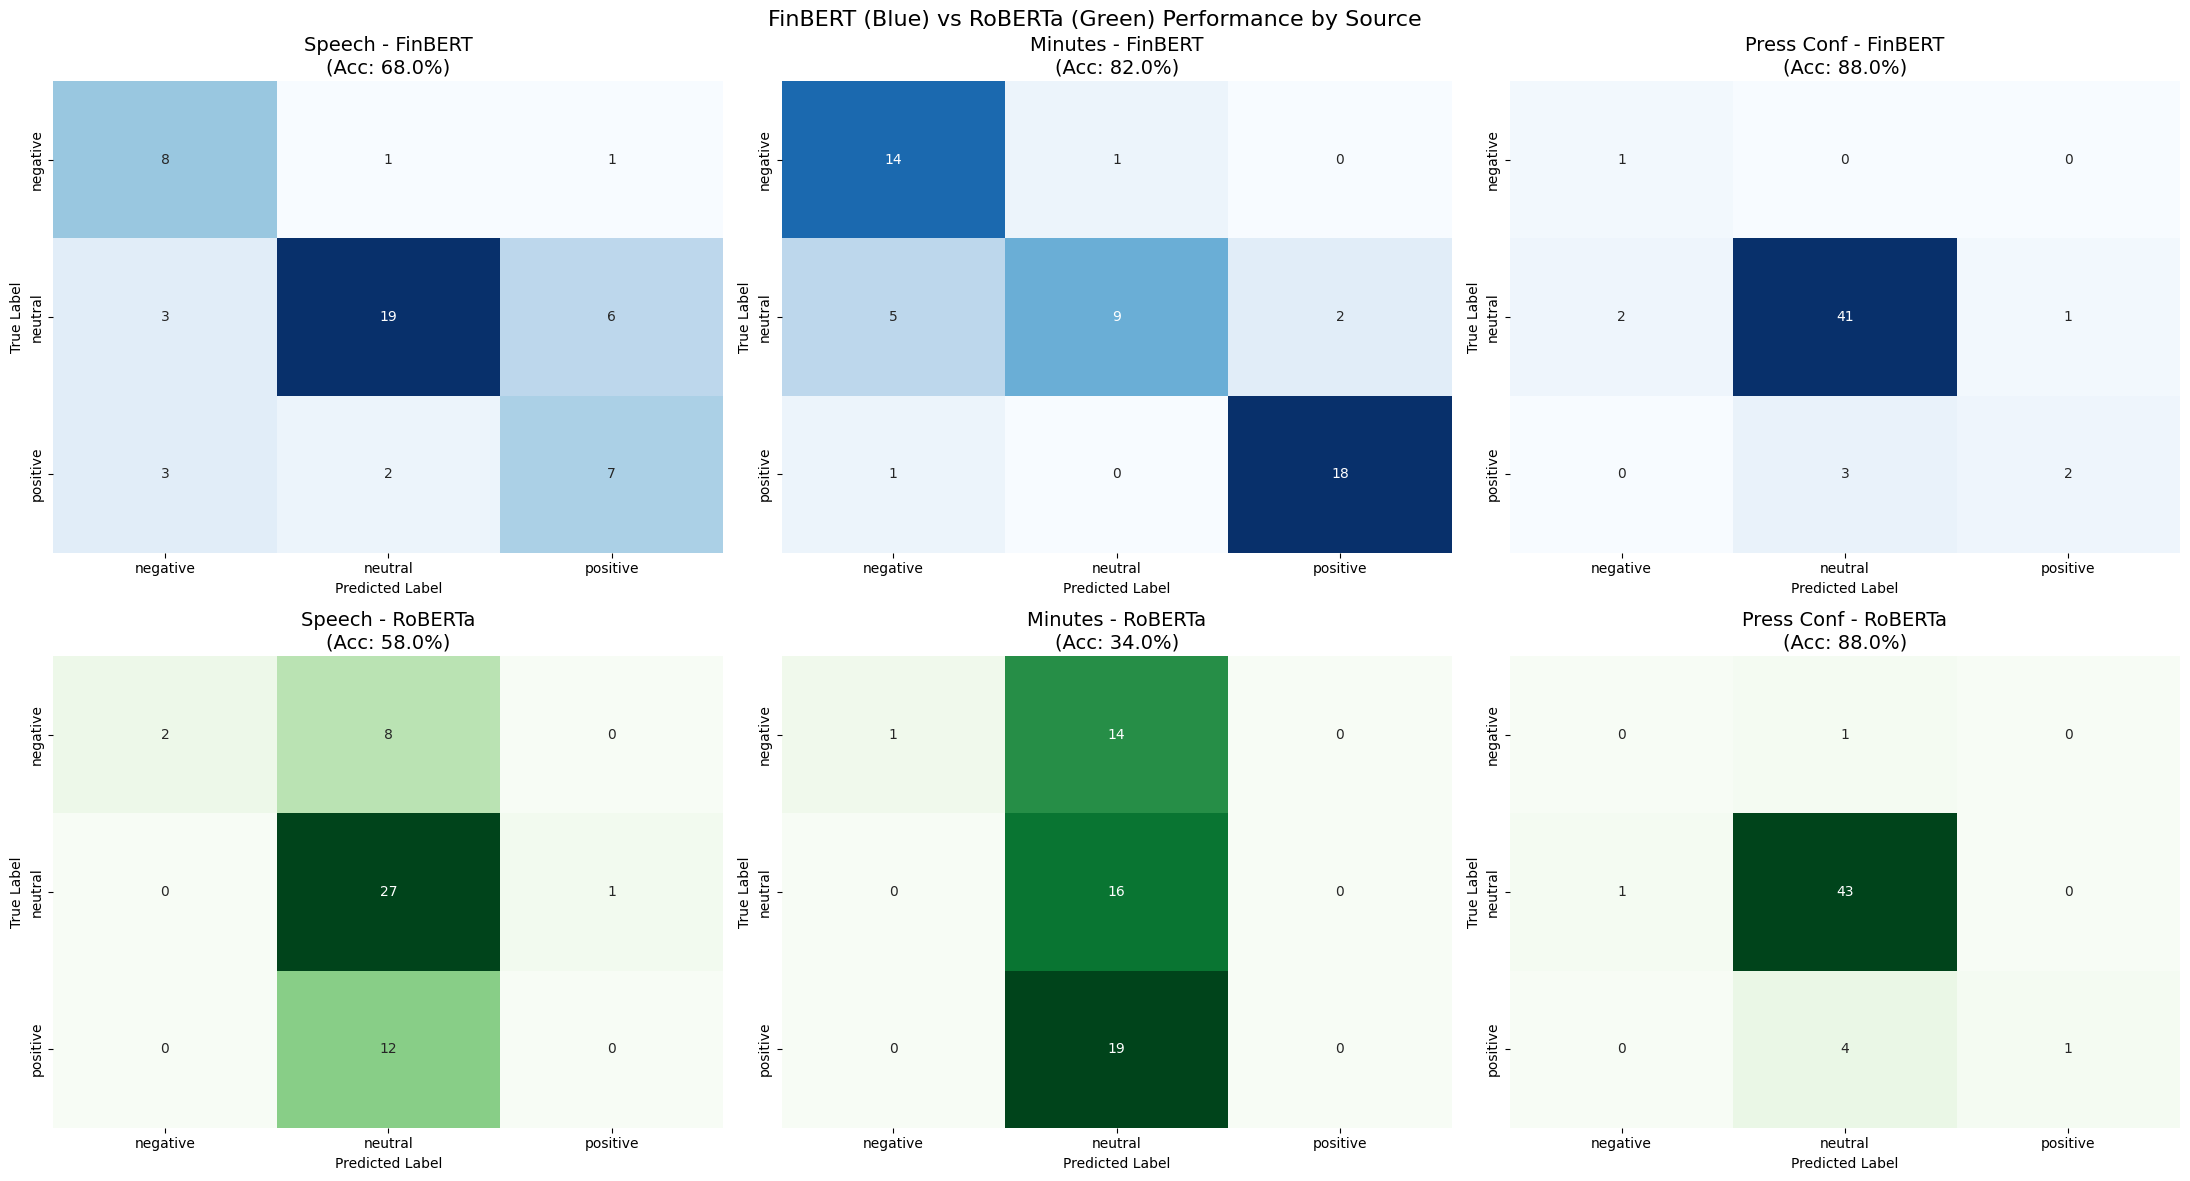


--- Accuracy Summary ---


,Baseline,FinBERT,RoBERTa
Source,,,
Speech,0.62,0.68,0.58
Minutes,0.40,0.82,0.34
Press Conf,0.82,0.88,0.88


In [3]:
sources = ['Speech', 'Minutes', 'Press Conf']
labels = ['negative', 'neutral', 'positive']

# Metrics Storage
source_metrics = []

# Create 2x3 subplot grid (Row 1: FinBERT, Row 2: RoBERTa)
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

for i, src in enumerate(sources):
    # 1. Filter Data
    subset = df_gold[df_gold['source'] == src]
    
    if len(subset) == 0:
        continue
        
    # 2. Calculate Metrics
    acc_b = accuracy_score(subset['label'], subset['baseline_pred'])
    acc_f = accuracy_score(subset['label'], subset['finbert_pred'])
    acc_r = accuracy_score(subset['label'], subset['roberta_pred'])
    
    source_metrics.append({'Source': src, 'Baseline': acc_b, 'FinBERT': acc_f, 'RoBERTa': acc_r})
    
    print(f"\n{'='*30}\nANALYSIS: {src.upper()} (n={len(subset)})\n{'='*30}")
    print(f"Baseline Accuracy: {acc_b:.2%}")
    print(f"FinBERT Accuracy:  {acc_f:.2%}")
    print(f"RoBERTa Accuracy:  {acc_r:.2%}")
    
    print("\nClassification Report (FinBERT):")
    print(classification_report(subset['label'], subset['finbert_pred'], zero_division=0))
    print("\nClassification Report (RoBERTa):")
    print(classification_report(subset['label'], subset['roberta_pred'], zero_division=0))
    
    # 3. FinBERT Heatmap (Row 0)
    cm_f = confusion_matrix(subset['label'], subset['finbert_pred'], labels=labels)
    sns.heatmap(cm_f, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues', ax=axes[0, i], cbar=False)
    axes[0, i].set_title(f'{src} - FinBERT\n(Acc: {acc_f:.1%})', fontsize=14)
    axes[0, i].set_xlabel('Predicted Label')
    axes[0, i].set_ylabel('True Label')
    
    # 4. RoBERTa Heatmap (Row 1)
    cm_r = confusion_matrix(subset['label'], subset['roberta_pred'], labels=labels)
    sns.heatmap(cm_r, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Greens', ax=axes[1, i], cbar=False)
    axes[1, i].set_title(f'{src} - RoBERTa\n(Acc: {acc_r:.1%})', fontsize=14)
    axes[1, i].set_xlabel('Predicted Label')
    axes[1, i].set_ylabel('True Label')

plt.suptitle(f'FinBERT (Blue) vs RoBERTa (Green) Performance by Source', fontsize=16)
plt.tight_layout()
plt.show()

# Summary Table
print("\n--- Accuracy Summary ---")
display(pd.DataFrame(source_metrics).set_index('Source'))

## 4. Error Analysis (Qualitative)
Inspecting specific failures for both models.

In [4]:
pd.set_option('display.max_colwidth', None)

for src in sources:
    print(f"\n>>> Misclassifications: {src} <<<")
    # Show where RoBERTa failed
    errors = df_gold[(df_gold['source'] == src) & (df_gold['label'] != df_gold['roberta_pred'])].copy()
    
    if len(errors) > 0:
        print(f"RoBERTa Errors: {len(errors)}")
        # Show random 3 examples if many errors, else show all
        show_n = min(3, len(errors))
        cols = ['text', 'label', 'finbert_pred', 'roberta_pred']
        display(errors[cols].sample(n=show_n, random_state=42) if len(errors) > 3 else errors[cols])
    else:
        print("RoBERTa: Perfect prediction.")


>>> Misclassifications: Speech <<<
RoBERTa Errors: 21


,text,label,finbert_pred,roberta_pred
12,Concerns over de-anchoring contributed to the view that disinflation would require slack in the economy and specifically in the labor market.,negative,negative,neutral
121,"We will only reach our full potential when everyone can contribute to, and share in, the benefits of prosperity.",positive,neutral,neutral
101,Greenspan was also right that the potential growth rate had shifted up.,positive,positive,neutral



>>> Misclassifications: Minutes <<<
RoBERTa Errors: 33


,text,label,finbert_pred,roberta_pred
139,"However, financing conditions for businesses and households generally remained supportive of economic growth.",positive,positive,neutral
67,"Short-term funding markets were stable, while participation in the ON RRP facility increased further, to its highest level since the facility was put in place.",positive,positive,neutral
126,"In the medium-term projection, real GDP growth was forecast to run at a rate similar to the staff's estimate of potential output growth in 2019 and 2020--a somewhat lower trajectory, on net, for real GDP than in the previous projection--and then slow to a pace below potential output growth in 2021.",negative,negative,neutral



>>> Misclassifications: Press Conf <<<
RoBERTa Errors: 6


,text,label,finbert_pred,roberta_pred
3,Right. So you’re right. We are committed to using our full range of tools to support the,positive,positive,neutral
55,"I think that shelter inflation is going to remain high for some time. We’re looking for it to come down, but it’s not exactly clear when that will happen. So it may",negative,negative,neutral
120,"No. We’re going to write down new forecasts at the March meeting, and we’ll see at that time. I will say that it is gratifying to see the disinflationary process now",positive,neutral,neutral
